# EVALUATE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score
)

In [2]:
prediction_test1_best = pd.read_csv(r"result\predictions_test1_best.csv")
prediction_test1_lora = pd.read_csv(r"result\predictions_test1_LoRA.csv")
prediction_test1_ml = pd.read_csv(r"result\predictions_test1_ML.csv")

prediction_test2_best = pd.read_csv(r"result\predictions_test2_best.csv")
prediction_test2_lora = pd.read_csv(r"result\predictions_test2_LoRA.csv")
prediction_test2_ml = pd.read_csv(r"result\predictions_test2_ML.csv")

In [3]:
def calculate_metrics(true_labels, predicted_labels, predicted_probabilities):
    """
    Calculate key classification metrics.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    sensitivity = recall_score(true_labels, predicted_labels)  # Sensitivity = Recall
    specificity = recall_score(true_labels, predicted_labels, pos_label=0)
    f1score = f1_score(true_labels, predicted_labels)

    return accuracy, precision, sensitivity, specificity, f1score

def bootstrap_auc_ci(true_labels, predicted_probabilities, n_bootstrap_samples=10000):
    """
    Compute the AUC confidence interval using bootstrap resampling.
    """
    auc_scores = []
    for _ in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(len(true_labels), len(true_labels), replace=True)
        bootstrap_scores = predicted_probabilities[bootstrap_indices]
        bootstrap_labels = true_labels[bootstrap_indices]

        unique_classes = np.unique(bootstrap_labels)
        if len(unique_classes) < 2:
            continue  # Skip bootstrap samples with only one class

        auc_scores.append(roc_auc_score(bootstrap_labels, bootstrap_scores))

    lower_bound = np.percentile(auc_scores, 2.5)
    upper_bound = np.percentile(auc_scores, 97.5)
    
    return lower_bound, upper_bound

def bootstrap_ci(metric_function, true_labels, predicted_labels, n_bootstrap_samples=5000):
    """
    Compute confidence intervals for a given metric using bootstrap resampling.
    """
    scores = []
    for _ in range(n_bootstrap_samples):
        bootstrap_indices = np.random.choice(len(true_labels), len(true_labels), replace=True)
        bootstrap_true = true_labels[bootstrap_indices]
        bootstrap_pred = predicted_labels[bootstrap_indices]

        unique_classes = np.unique(bootstrap_true)
        if len(unique_classes) < 2:
            continue  # Skip bootstrap samples with only one class

        scores.append(metric_function(bootstrap_true, bootstrap_pred))

    lower_bound = np.percentile(scores, 2.5)
    upper_bound = np.percentile(scores, 97.5)
    
    return lower_bound, upper_bound

def evaluate_predictions_with_ci(df):
    """
    Evaluate predictions by computing metrics and their confidence intervals.
    """
    true_labels = df['true_label'].values
    predicted_probabilities = df['predicted_probability'].values
    predicted_labels = (predicted_probabilities >= 0.5).astype(int)

    # Compute metrics
    accuracy, precision, sensitivity, specificity, f1score = calculate_metrics(true_labels, predicted_labels, predicted_probabilities)

    # Compute confidence intervals for each metric
    acc_lower, acc_upper = bootstrap_ci(accuracy_score, true_labels, predicted_labels)
    prec_lower, prec_upper = bootstrap_ci(precision_score, true_labels, predicted_labels)
    sens_lower, sens_upper = bootstrap_ci(recall_score, true_labels, predicted_labels)
    spec_lower, spec_upper = bootstrap_ci(lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=0), true_labels, predicted_labels)
    f1_lower, f1_upper = bootstrap_ci(f1_score, true_labels, predicted_labels)

    # Compute AUC
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)

    # Compute AUC confidence interval
    auc_lower, auc_upper = bootstrap_auc_ci(true_labels, predicted_probabilities)

    # Print metrics and confidence intervals
    print("--------------------- Metrics and Prediction Details ---------------------")
    print(f"Accuracy: {accuracy:.8f} (95% CI: [{acc_lower:.8f}, {acc_upper:.8f}])")
    print(f"Precision: {precision:.8f} (95% CI: [{prec_lower:.8f}, {prec_upper:.8f}])")
    print(f"Sensitivity (Recall): {sensitivity:.8f} (95% CI: [{sens_lower:.8f}, {sens_upper:.8f}])")
    print(f"Specificity: {specificity:.8f} (95% CI: [{spec_lower:.8f}, {spec_upper:.8f}])")
    print(f"F1-score: {f1score:.8f} (95% CI: [{f1_lower:.8f}, {f1_upper:.8f}])")
    print(f"AUC: {roc_auc:.8f} (95% CI: [{auc_lower:.8f}, {auc_upper:.8f}])")

In [ ]:
print("Test 1-----------------------------------")
print("LoRA + Retriever: ")
evaluate_predictions_with_ci(prediction_test1_best)
print("\nLoRA:")
evaluate_predictions_with_ci(prediction_test1_lora)
print("\nML:")
evaluate_predictions_with_ci(prediction_test1_ml)


print("\n\nTest 2-----------------------------------")
print("LoRA + Retriever: ")
evaluate_predictions_with_ci(prediction_test2_best)
print("\nLoRA:")
evaluate_predictions_with_ci(prediction_test2_lora)
print("\nML:")
evaluate_predictions_with_ci(prediction_test2_ml)

Test 1-----------------------------------
LoRA + Retriever: 
--------------------- Metrics and Prediction Details ---------------------
Accuracy: 0.98531012 (95% CI: [0.97986942, 0.99075082])
Precision: 0.97597598 (95% CI: [0.96613505, 0.98519323])
Sensitivity (Recall): 0.99693252 (95% CI: [0.99286442, 1.00000000])
Specificity: 0.97209302 (95% CI: [0.96094651, 0.98277940])
F1-score: 0.98634294 (95% CI: [0.98109453, 0.99131346])
AUC: 0.99898821 (95% CI: [0.99824321, 0.99955348])

LoRA:
--------------------- Metrics and Prediction Details ---------------------
Accuracy: 0.94994559 (95% CI: [0.94015234, 0.95919478])
Precision: 0.92596154 (95% CI: [0.90971508, 0.94190583])
Sensitivity (Recall): 0.98466258 (95% CI: [0.97672065, 0.99193548])
Specificity: 0.91046512 (95% CI: [0.89090858, 0.92873310])
F1-score: 0.95441031 (95% CI: [0.94464106, 0.96328513])
AUC: 0.97087376 (95% CI: [0.96228041, 0.97880253])

ML:
--------------------- Metrics and Prediction Details ---------------------
Accuracy

In [15]:
from scipy.interpolate import interp1d

def plot_confusion_matrices(predictions):
    """
    Plot confusion matrices for multiple models in subplots.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    num_models = len(predictions)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))

    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable when only one model exists

    for ax, (model_name, df) in zip(axes, predictions.items()):
        true_labels = df['true_label'].values
        predicted_labels = (df['predicted_probability'].values >= 0.5).astype(int)

        cm = confusion_matrix(true_labels, predicted_labels)
        cm[[1, 0]] = cm[[0, 1]]  # Swap rows to align with visualization

        im = ax.imshow(cm, cmap='Blues')
        ax.set_title(f"Confusion Matrix - {model_name}", fontsize=16)
        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Negative", "Positive"], fontsize=14)
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["Positive", "Negative"], fontsize=14)
        ax.set_xlabel('Predicted Label', fontsize=14)
        ax.set_ylabel('True Label', fontsize=14)

        # Annotate cells with counts
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                        fontsize=14,
                        color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()


def plot_roc_curves(predictions):
    """
    Plot ROC curves for multiple models on the same plot.
    """
    plt.figure(figsize=(6, 6))

    for model_name, df in predictions.items():
        true_labels = df['true_label'].values
        predicted_probabilities = df['predicted_probability'].values

        fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
        roc_auc = auc(fpr, tpr)

        # Remove duplicate FPR values (keep the first occurrence)
        unique_fpr, unique_indices = np.unique(fpr, return_index=True)
        unique_tpr = tpr[unique_indices]

        # Ensure FPR has enough points for interpolation
        if len(unique_fpr) > 1:
            fpr_smooth = np.linspace(unique_fpr.min(), unique_fpr.max(), 200)
            tpr_smooth = interp1d(unique_fpr, unique_tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)
        else:
            fpr_smooth = unique_fpr
            tpr_smooth = unique_tpr  # No interpolation needed if only one point

        plt.plot(fpr_smooth, tpr_smooth, label=f'{model_name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()

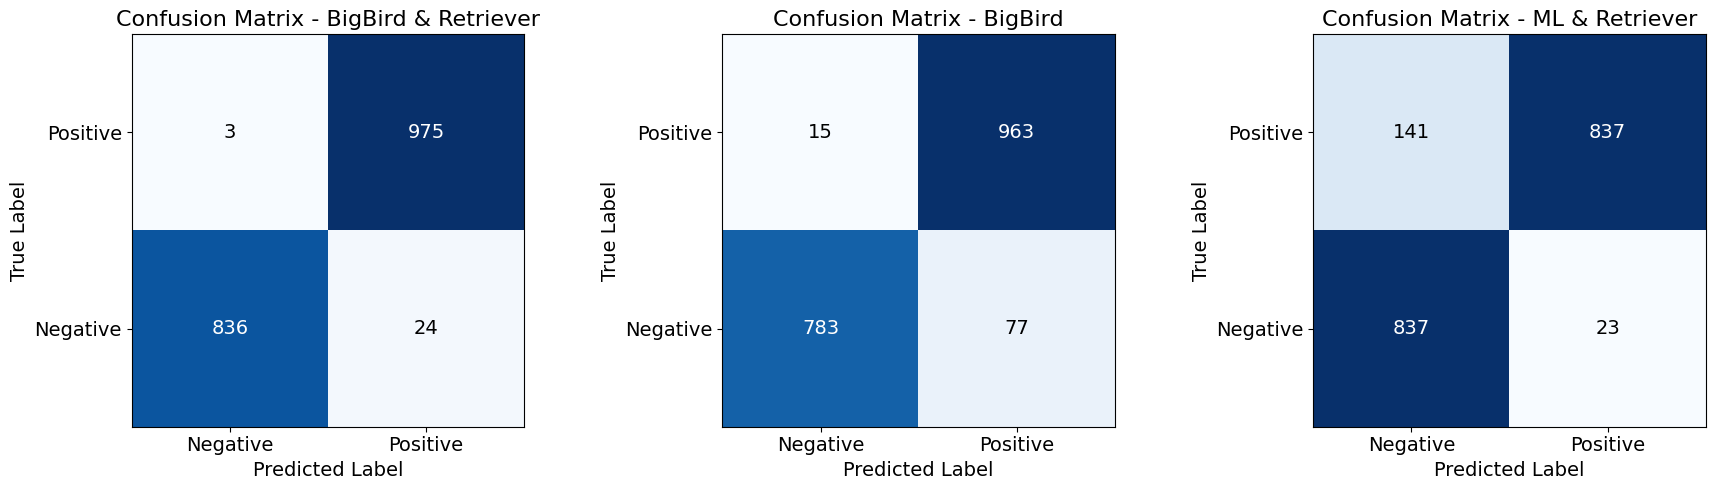

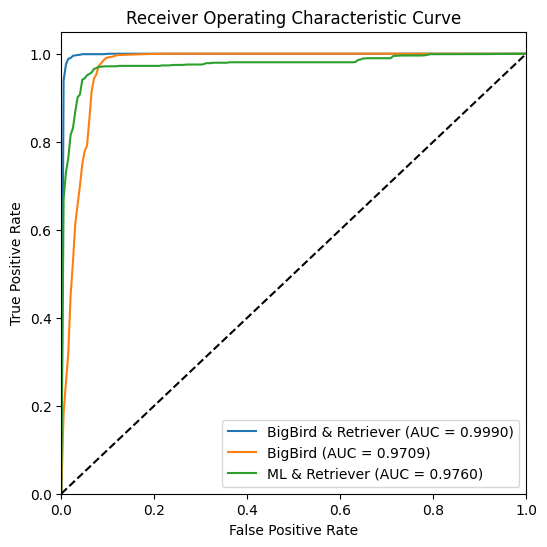

In [16]:
predictions_test1 = {
    "BigBird & Retriever": prediction_test1_best,
    "BigBird": prediction_test1_lora,
    "ML & Retriever": prediction_test1_ml
}
plot_confusion_matrices(predictions_test1)
plot_roc_curves(predictions_test1)

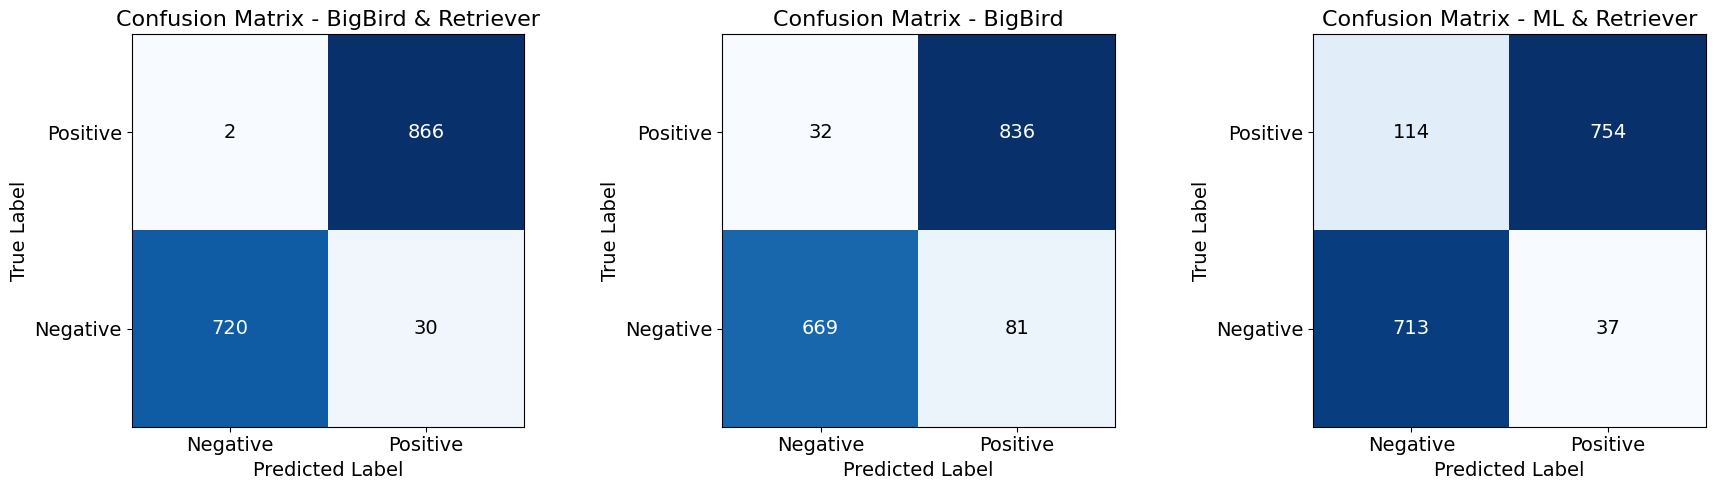

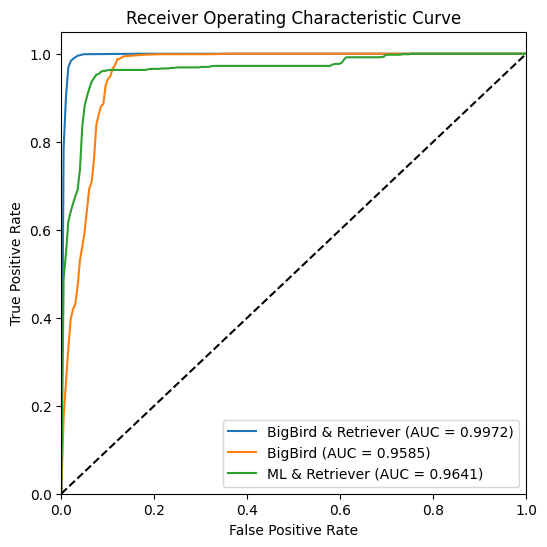

In [17]:
predictions_test2 = {
    "BigBird & Retriever": prediction_test2_best,
    "BigBird": prediction_test2_lora,
    "ML & Retriever": prediction_test2_ml
}
plot_confusion_matrices(predictions_test2)
plot_roc_curves(predictions_test2)